## **Moe Mowlai  - Traffic Sign Recognition**

The dataset used here is **German traffic sign from Kaggle.**\
It is a single image, multi-class classification problem with more than 40 classes and 50000 images. 
The data can be found [here](https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign).

Reference : https://benchmark.ini.rub.de/

In [ ]:
# Importing the needed libraries
import pandas as pd
import numpy as np
import seaborn as sns
import cv2, os
import itertools

import warnings
warnings.filterwarnings('ignore')
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras import *
from tensorflow import keras
from keras.metrics import categorical_accuracy
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.layers import Input, Reshape, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation, BatchNormalization
from keras.layers import LSTM, multiply, GaussianNoise, Embedding, ZeroPadding2D, Convolution2D, GRU, Bidirectional, GlobalMaxPooling1D, Lambda, Concatenate
from keras.layers.convolutional import UpSampling2D
from IPython.display import clear_output
from keras.models import Sequential, load_model, Model
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.optimizers import *

In [ ]:
# Here we load the data.

# First we load the kaggle authenticate token

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


In [ ]:
!kaggle datasets download -d **********************************

 99% 607M/612M [00:05<00:00, 142MB/s]
100% 612M/612M [00:05<00:00, 112MB/s]


In [ ]:
!unzip gtsrb-german-traffic-sign.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/5/00005_00053_00010.png  
  inflating: train/5/00005_00053_00011.png  
  inflating: train/5/00005_00053_00012.png  
  inflating: train/5/00005_00053_00013.png  
  inflating: train/5/00005_00053_00014.png  
  inflating: train/5/00005_00053_00015.png  
  inflating: train/5/00005_00053_00016.png  
  inflating: train/5/00005_00053_00017.png  
  inflating: train/5/00005_00053_00018.png  
  inflating: train/5/00005_00053_00019.png  
  inflating: train/5/00005_00053_00020.png  
  inflating: train/5/00005_00053_00021.png  
  inflating: train/5/00005_00053_00022.png  
  inflating: train/5/00005_00053_00023.png  
  inflating: train/5/00005_00053_00024.png  
  inflating: train/5/00005_00053_00025.png  
  inflating: train/5/00005_00053_00026.png  
  inflating: train/5/00005_00053_00027.png  
  inflating: train/5/00005_00053_00028.png  
  inflating: train/5/00005_00053_00029.png  
  inflating: train/5/00005_00054_00000.png  
  in

### EDA and Data prepration

We first read, resize and normalize the images of training dataset which is in Train folder.

In [ ]:
# loading dataset and extracting the lables and images
data = []
labels = []

for lable in os.listdir("Train"):
    dir = "Train/"+ lable
    for img_num in os.listdir(dir):
        # path to every image in every class of Train folder
        img_path = dir+'/'+ img_num
        img = cv2.imread(img_path,-1)
        # resizing the images
        img = cv2.resize(img, (30,30), interpolation = cv2.INTER_NEAREST)
        data.append(img)
        labels.append(lable)
        
X = np.array(data)
# Normalizing
X = X / 255 
y = np.array(labels).astype(np.float)


Split them into train and validation

In [ ]:
# train, validation split

validation_split = 0.2 #@param {type:"slider", min:0.1, max:0.4, step:0.1}
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=validation_split, random_state=42)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(31367, 30, 30, 3) (31367,)
(7842, 30, 30, 3) (7842,)


In [ ]:
# read the Training.csv and Test.csv files into dataframes
training_dataframe = pd.read_csv('Train.csv')
test_dataframe = pd.read_csv('Test.csv')

In [ ]:
training_dataframe

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png
...,...,...,...,...,...,...,...,...
39204,52,56,5,6,47,51,42,Train/42/00042_00007_00025.png
39205,56,58,5,5,51,53,42,Train/42/00042_00007_00026.png
39206,58,62,5,6,53,57,42,Train/42/00042_00007_00027.png
39207,63,69,5,7,58,63,42,Train/42/00042_00007_00028.png


In [ ]:
test_dataframe

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png
...,...,...,...,...,...,...,...,...
12625,42,41,5,6,37,36,12,Test/12625.png
12626,50,51,6,5,45,46,33,Test/12626.png
12627,29,29,6,6,24,24,6,Test/12627.png
12628,48,49,5,6,43,44,7,Test/12628.png


In [ ]:
# Calculate the number of unique classes which are 43
NUM_CLASSES = training_dataframe['ClassId'].nunique() 
TRAIN_LEN = training_dataframe['ClassId'].count()
print("Number of Classes: ", NUM_CLASSES) # dataset contains 43 classes

Number of Classes:  43


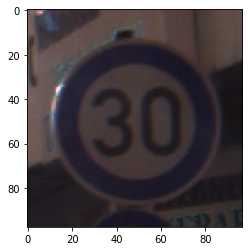

In [ ]:
# Visualizing an image
plt.imshow(cv2.imread("Train/1/00001_00072_00027.png", -1))

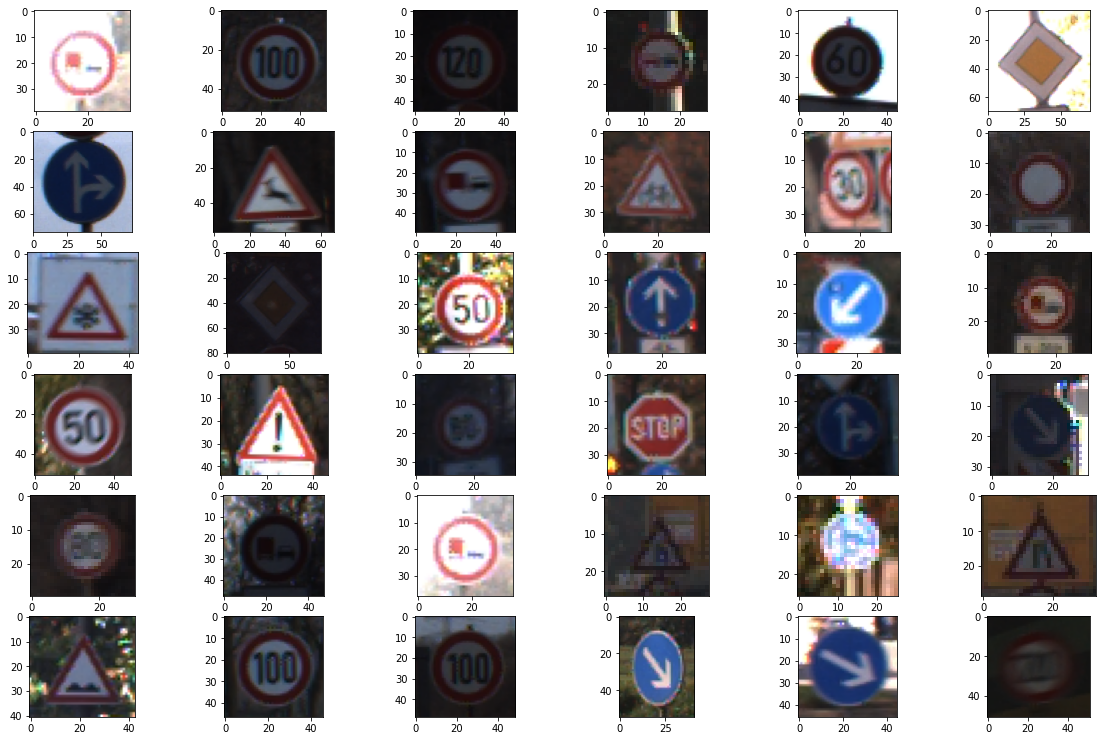

In [ ]:
# Visualizing some random images
sample = plt.subplots(6,6, figsize=(20,13))
for i in range(36):
    plt.subplot(6,6,i+1) 
    # Plot A Random Image
    plt.imshow(plt.imread(training_dataframe["Path"][np.random.randint(TRAIN_LEN)]))

plt.show()

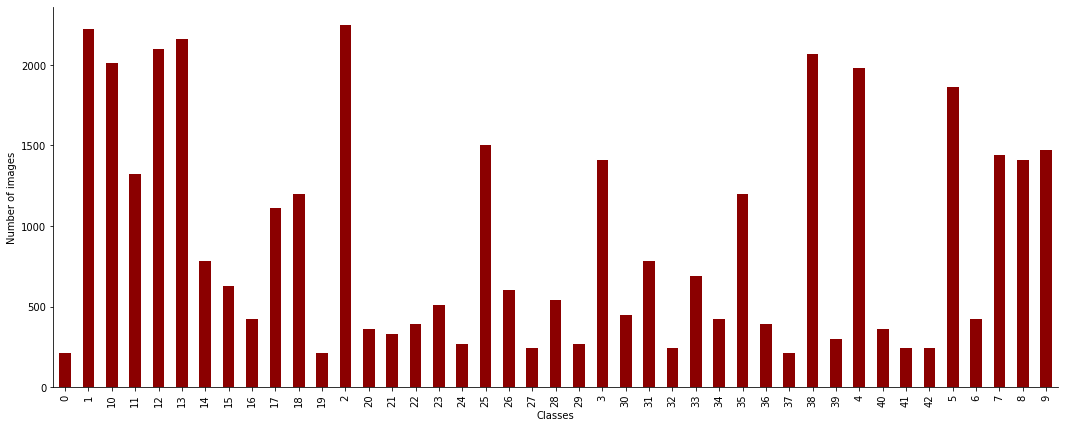

In [ ]:
# number of images in each class
class_dic = {}
for classes in os.listdir("Train/"):
    class_dic[classes] = len(os.listdir("Train/" + classes))

class_df= pd.Series(class_dic)
plt.figure(figsize = (18, 7))
class_df.sort_index().plot(kind = 'bar', color="darkred")
plt.xlabel('Classes')
plt.ylabel('Number of images')
sns.despine()

There are **43** classes of images.

In [ ]:
CLASS_NAMES = { 0:'Speed limit (20km/h)', 1:'Speed limit (30km/h)', 2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 4:'Speed limit (70km/h)', 5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 7:'Speed limit (100km/h)', 8:'Speed limit (120km/h)', 9:'No passing', 
            10:'No passing veh over 3.5 tons', 11:'Right-of-way at intersection', 12:'Priority road', 13:'Yield', 
            14:'Stop', 15:'No vehicles', 16:'Veh > 3.5 tons prohibited', 17:'No entry', 
            18:'General caution', 19:'Dangerous curve left', 20:'Dangerous curve right', 
            21:'Double curve', 22:'Bumpy road', 23:'Slippery road', 24:'Road narrows on the right', 
            25:'Road work', 26:'Traffic signals', 27:'Pedestrians', 28:'Children crossing', 
            29:'Bicycles crossing', 30:'Beware of ice/snow', 31:'Wild animals crossing', 
            32:'End speed + passing limits', 33:'Turn right ahead', 34:'Turn left ahead', 
            35:'Ahead only', 36:'Go straight or right', 37:'Go straight or left', 38:'Keep right', 
            39:'Keep left', 40:'Roundabout mandatory', 41:'End of no passing', 42:'End no passing veh > 3.5 tons'}

Data Augmentation

In [ ]:
def augment(path, class_num):
    # A function to perform data augmentation (in this case, randomly change the
    # brightness and randomly flip the image left/right)
    image = cv2.imread(path, -1)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_flip_left_right(image)
    label = CLASS_NAMES[class_num]
    return plt.imshow(image), label

Sample augmented image:

(<matplotlib.image.AxesImage at 0x7f2ffd777c50>, 'Dangerous curve right')

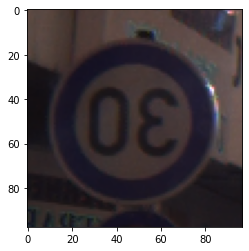

In [ ]:
augment("Train/1/00001_00072_00027.png",20)

### Model: 

#### Baseline Model

This section is about the model prepration and implementation. \
The model creation function is as follow. It consist of Convultion layers along with batch normalization, max pooling and dropout. 

In [ ]:
# Constructing the Model:
def baseline_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu', input_shape=(30, 30, 3), kernel_regularizer=tf.keras.regularizers.l2(1e-3)))
    model.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-3)))
    model.add(BatchNormalization())
    

    model.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-3)))
    model.add(Conv2D(256, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    

    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-3)))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-3)))
    model.add(Dropout(0.2))
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

cnn_model = baseline_model()

In [ ]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 15, 15, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 8, 8, 64)          256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 256)         819456    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 256)         0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 1, 1, 256)         1

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
#@title You can edit the hyperparameters
epochs = 45 #@param {type:"slider", min:1, max:200, step:1}
batch_size = 32 #@param {type:"slider", min:8, max:1024, step:8}

classifier = cnn_model.fit(
          x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_valid, y_valid))

Epoch 1/45
981/981 [==============================] - 55s 56ms/step - loss: 1.4330 - accuracy: 0.6913 - val_loss: 0.7264 - val_accuracy: 0.8962
Epoch 2/45
981/981 [==============================] - 44s 45ms/step - loss: 0.7363 - accuracy: 0.9030 - val_loss: 0.6346 - val_accuracy: 0.9375
Epoch 3/45
981/981 [==============================] - 50s 51ms/step - loss: 0.6622 - accuracy: 0.9346 - val_loss: 0.5689 - val_accuracy: 0.9616
Epoch 4/45
981/981 [==============================] - 43s 44ms/step - loss: 0.6358 - accuracy: 0.9453 - val_loss: 0.6041 - val_accuracy: 0.9563
Epoch 5/45
981/981 [==============================] - 43s 44ms/step - loss: 0.6245 - accuracy: 0.9497 - val_loss: 0.5730 - val_accuracy: 0.9663
Epoch 6/45
981/981 [==============================] - 43s 44ms/step - loss: 0.6117 - accuracy: 0.9560 - val_loss: 0.5864 - val_accuracy: 0.9623
Epoch 7/45
981/981 [==============================] - 43s 44ms/step - loss: 0.6046 - accuracy: 0.9576 - val_loss: 0.6071 - val_accuracy:

Visulization of the loss and accuracy of the model

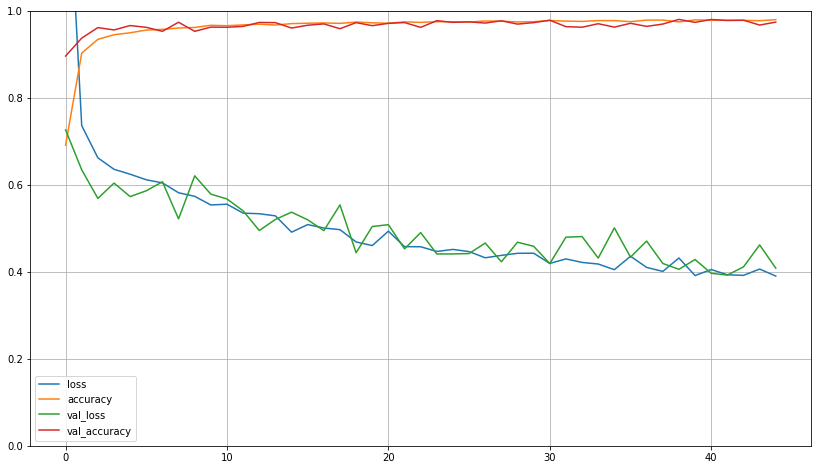

In [ ]:
pd.DataFrame(classifier.history).plot(figsize=(14,8))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Let's try to test it on the test data.

In [ ]:
# Model performence on test dataset
y_test = test_dataframe["ClassId"].values
imgs = test_dataframe["Path"].values
data =[]
for img in imgs:
    image = cv2.imread(img)
    image_fromarray = Image.fromarray(image, 'RGB')
    resize_image = image_fromarray.resize((30, 30))
    data.append(np.array( resize_image ))

x_test = np.array(data)
x_test = x_test/255
cnn_model.evaluate(x_test, y_test)

395/395 [==============================] - 9s 24ms/step - loss: 0.7171 - accuracy: 0.9089


[0.7170856595039368, 0.9088677763938904]

In [ ]:
# Loading the model
cnn_model = keras.models.load_model('cnn_model.hdf5')

#### Baseline without Last dense layer and batch normalizations

In [ ]:
# Constructing the Model:
def baseline_edited_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu', input_shape=(30, 30, 3), kernel_regularizer=tf.keras.regularizers.l2(1e-3)))
    model.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-3)))
    
    model.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-3)))
    model.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    

    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-3)))

    model.add(Dense(NUM_CLASSES, activation='softmax'))

    model.compile(optimizer='SGD', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

cnn_edited_model = baseline_edited_model()

In [ ]:
cnn_edited_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 15, 15, 32)        2432      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 8, 8, 64)          51264     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 4, 4, 64)          102464    
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 2, 2, 64)          102464    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
module_wrapper_35 (ModuleWra (None, 1, 1, 64)          0         
_________________________________________________________________
module_wrapper_36 (ModuleWra (None, 64)               

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
#@title You can edit the hyperparameters
epochs = 45 #@param {type:"slider", min:1, max:200, step:1}
batch_size = 32 #@param {type:"slider", min:8, max:1024, step:8}

classifier = cnn_edited_model.fit(
          x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_valid, y_valid))

Epoch 1/45
981/981 [==============================] - 38s 39ms/step - loss: 3.8448 - accuracy: 0.0562 - val_loss: 3.6468 - val_accuracy: 0.1075
Epoch 2/45
981/981 [==============================] - 38s 39ms/step - loss: 3.5720 - accuracy: 0.1076 - val_loss: 3.1964 - val_accuracy: 0.1807
Epoch 3/45
981/981 [==============================] - 37s 38ms/step - loss: 2.7355 - accuracy: 0.3106 - val_loss: 1.6546 - val_accuracy: 0.5506
Epoch 4/45
981/981 [==============================] - 37s 37ms/step - loss: 1.5450 - accuracy: 0.5860 - val_loss: 1.0493 - val_accuracy: 0.7325
Epoch 5/45
981/981 [==============================] - 37s 38ms/step - loss: 1.0735 - accuracy: 0.7231 - val_loss: 0.7760 - val_accuracy: 0.8106
Epoch 6/45
981/981 [==============================] - 37s 38ms/step - loss: 0.8622 - accuracy: 0.7900 - val_loss: 0.7697 - val_accuracy: 0.8147
Epoch 7/45
981/981 [==============================] - 37s 38ms/step - loss: 0.7591 - accuracy: 0.8223 - val_loss: 0.6066 - val_accuracy:

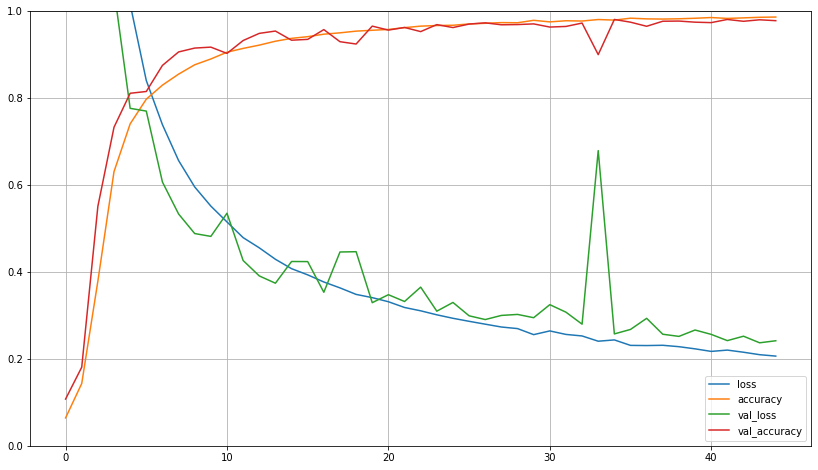

In [ ]:
pd.DataFrame(classifier.history).plot(figsize=(14,8))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
# Model performence on test dataset
y_test = test_dataframe["ClassId"].values
imgs = test_dataframe["Path"].values
data =[]
for img in imgs:
    image = cv2.imread(img)
    image_fromarray = Image.fromarray(image, 'RGB')
    resize_image = image_fromarray.resize((30, 30))
    data.append(np.array( resize_image ))

x_test = np.array(data)
x_test = x_test/255
cnn_edited_model.evaluate(x_test, y_test)

395/395 [==============================] - 9s 23ms/step - loss: 0.6763 - accuracy: 0.8781


[0.6762591600418091, 0.8780680894851685]

#### LSTM

In [ ]:
import gc
del X, y, x_train, y_train, x_valid, y_valid
gc.collect()

21838

In [ ]:
# loading dataset and extracting the lables and images
data2 = []
labels = []

for lable in os.listdir("Train"):
    dir = "Train/"+ lable
    for img_num in os.listdir(dir):
        # path to every image in every class of Train folder
        img_path = dir+'/'+ img_num
        img = cv2.imread(img_path,-1)
        # resizing the images
        img = cv2.resize(img, (30,30), interpolation = cv2.INTER_NEAREST)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        data2.append(img)
        labels.append(lable)
        
X = np.array(data2)
# Normalizing
X = X / 255 
y = np.array(labels).astype(np.float)


In [ ]:
# train, validation split

validation_split = 0.2 #@param {type:"slider", min:0.1, max:0.4, step:0.1}
x_train2, x_valid2, y_train2, y_valid2 = train_test_split(X, y, test_size=validation_split, random_state=42)
print(x_train2.shape, y_train2.shape)
print(x_valid2.shape, y_valid2.shape)

(31367, 30, 30) (31367,)
(7842, 30, 30) (7842,)


In [ ]:
def lstm_model():
  model = keras.models.Sequential()

  model.add(keras.Input(shape=(30,30)))
  model.add(layers.Reshape((30,30,1),input_shape = (30,30)))
  model.add(keras.layers.Conv2D(4,(3,3),(1,1),activation='relu',input_shape = (30,30,1)))
  model.add(layers.MaxPool2D((2,2)))
  model.add(layers.Reshape((14,56),input_shape = (14,14,4)))
  model.add(layers.Dropout(0.05))
  model.add(layers.LSTM(128))
  model.add(layers.Dense(43,activation='softmax'))
  
  loss = keras.losses.sparse_categorical_crossentropy
  optimizer = keras.optimizers.Adam(learning_rate = 0.001)
  metrics = ['accuracy']

  model.compile(optimizer=optimizer,loss=loss,metrics=metrics)

  return model

In [ ]:
lstm = lstm_model()

In [ ]:
lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 30, 30, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 4)         40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 4)         0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 56)            0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 56)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               94720     
_________________________________________________________________
dense (Dense)                (None, 43)                5

In [ ]:
batch_size = 32
epochs = 40

history_lstm = lstm.fit(x_train2,y_train2,batch_size=batch_size,epochs=epochs,verbose=1, validation_data=(x_valid2, y_valid2))

Epoch 1/40
981/981 [==============================] - 39s 5ms/step - loss: 2.7044 - accuracy: 0.2445 - val_loss: 1.6805 - val_accuracy: 0.4871
Epoch 2/40
981/981 [==============================] - 5s 5ms/step - loss: 1.1956 - accuracy: 0.6320 - val_loss: 0.8681 - val_accuracy: 0.7246
Epoch 3/40
981/981 [==============================] - 5s 5ms/step - loss: 0.7097 - accuracy: 0.7759 - val_loss: 0.5744 - val_accuracy: 0.8168
Epoch 4/40
981/981 [==============================] - 5s 5ms/step - loss: 0.5016 - accuracy: 0.8426 - val_loss: 0.3968 - val_accuracy: 0.8805
Epoch 5/40
981/981 [==============================] - 5s 5ms/step - loss: 0.3862 - accuracy: 0.8791 - val_loss: 0.3855 - val_accuracy: 0.8798
Epoch 6/40
981/981 [==============================] - 5s 5ms/step - loss: 0.3097 - accuracy: 0.9045 - val_loss: 0.2712 - val_accuracy: 0.9151
Epoch 7/40
981/981 [==============================] - 5s 5ms/step - loss: 0.2618 - accuracy: 0.9175 - val_loss: 0.2230 - val_accuracy: 0.9336
Epoch

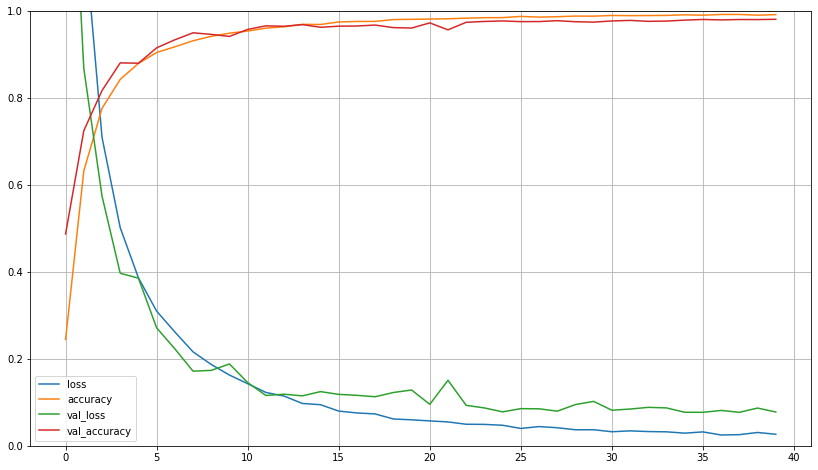

In [ ]:
pd.DataFrame(history_lstm.history).plot(figsize=(14,8))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
# Model performence on test dataset
y_test2 = test_dataframe["ClassId"].values
imgs = test_dataframe["Path"].values
data2 =[]
for img in imgs:
    image = cv2.imread(img,-1)
    image = cv2.resize(image, (30,30), interpolation = cv2.INTER_NEAREST)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    data2.append(image)

x_test2 = np.array(data2)
x_test2 = x_test2/255
lstm.evaluate(x_test2, y_test2)

395/395 [==============================] - 2s 3ms/step - loss: 0.4886 - accuracy: 0.8985


[0.4886193871498108, 0.8984956741333008]

In [ ]:
# Saving the model
tf.keras.models.save_model(lstm,'lstm_model.hdf5')

#### Transfer learning using Resnet50

In [ ]:
import gc
del X, y, x_train2, y_train2, x_valid2, y_valid2
#gc.collect()

In [ ]:
# loading dataset and extracting the lables and images
data3 = []
labels = []

for lable in os.listdir("Train"):
    dir = "Train/"+ lable
    for img_num in os.listdir(dir):
        # path to every image in every class of Train folder
        img_path = dir+'/'+ img_num
        img = cv2.imread(img_path,-1)
        # resizing the images
        img = cv2.resize(img, (32,32), interpolation = cv2.INTER_NEAREST)
        data3.append(img)
        labels.append(lable)
        
X = np.array(data3)
# Normalizing
X = X / 255 
y = np.array(labels).astype(np.float)


In [ ]:
# train, validation split

validation_split = 0.2 #@param {type:"slider", min:0.1, max:0.4, step:0.1}
x_train3, x_valid3, y_train3, y_valid3 = train_test_split(X, y, test_size=validation_split, random_state=42)
print(x_train3.shape, y_train3.shape)
print(x_valid3.shape, y_valid3.shape)

(31367, 32, 32, 3) (31367,)
(7842, 32, 32, 3) (7842,)


In [ ]:
from tensorflow.keras.applications import ResNet50
def create_resnet():
    # Initialize the Pretrained Model
    feature_extractor = ResNet50(weights='imagenet', 
                                input_shape=(32, 32, 3),
                                include_top=False)
    feature_extractor.trainable = False
    # Setting the input layer
    input_ = tf.keras.Input(shape=(32, 32, 3))
    x = feature_extractor(input_, training=False)

    x = tf.keras.layers.GlobalMaxPool2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    # Setting the final layer with sigmoid activation function
    output_ = tf.keras.layers.Dense(43, activation='sigmoid')(x)

    resnet_model = tf.keras.Model(input_, output_)

    resnet_model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return resnet_model

resnet_model = create_resnet()

resnet_model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 43)                2795      
Total params: 23,861,035
Trainable params: 273,323
Non-trainab

In [ ]:
hist_resnet = resnet_model.fit(x_train3,y_train3, epochs=45, validation_data=(x_valid3,y_valid3))

Epoch 1/45
981/981 [==============================] - 26s 23ms/step - loss: 3.3123 - accuracy: 0.1069 - val_loss: 3.0803 - val_accuracy: 0.1375
Epoch 2/45
981/981 [==============================] - 21s 22ms/step - loss: 2.8562 - accuracy: 0.1957 - val_loss: 2.8381 - val_accuracy: 0.2053
Epoch 3/45
981/981 [==============================] - 21s 22ms/step - loss: 2.6236 - accuracy: 0.2489 - val_loss: 2.5849 - val_accuracy: 0.2530
Epoch 4/45
981/981 [==============================] - 21s 22ms/step - loss: 2.4527 - accuracy: 0.2901 - val_loss: 2.3611 - val_accuracy: 0.3043
Epoch 5/45
981/981 [==============================] - 19s 20ms/step - loss: 2.3200 - accuracy: 0.3244 - val_loss: 2.3016 - val_accuracy: 0.3303
Epoch 6/45
981/981 [==============================] - 19s 20ms/step - loss: 2.2207 - accuracy: 0.3476 - val_loss: 2.3909 - val_accuracy: 0.3071
Epoch 7/45
981/981 [==============================] - 21s 22ms/step - loss: 2.1481 - accuracy: 0.3661 - val_loss: 2.1399 - val_accuracy:

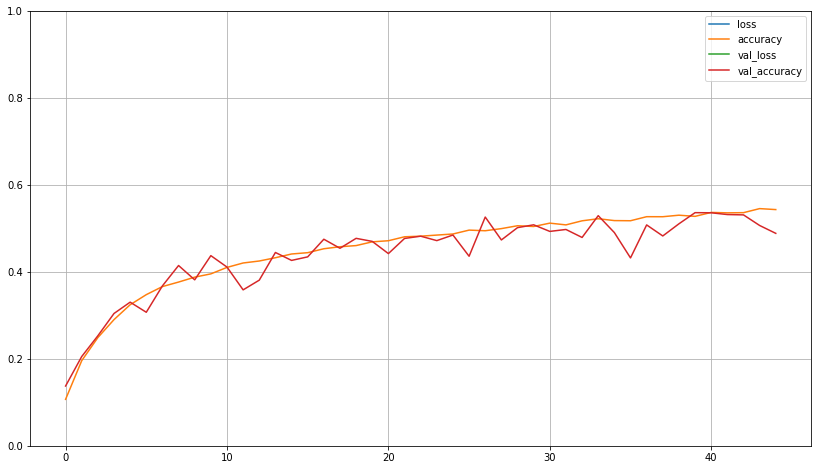

In [ ]:
pd.DataFrame(hist_resnet.history).plot(figsize=(14,8))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
# Saving the model
tf.keras.models.save_model(resnet_model,'resnet_model.hdf5')

#### VGG

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input,decode_predictions

In [ ]:
def create_vgg():  
    model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
    input = Input(shape=(32,32,3),name = 'image_input')
    output_vgg16_conv = model_vgg16_conv(input)

    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(256, activation='relu', name='fc1')(x)
    x = Dense(128, activation='relu', name='fc2')(x)
    x = Dense(43, activation='softmax', name='predictions')(x)


    vgg16_model = tf.keras.Model(input, x)

    return vgg16_model

vgg16_model = create_vgg()

The following Variables were used a Lambda layer's call (tf.nn.convolution_78), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_78), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_79), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this

In [ ]:
vgg16_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf.nn.convolution_65 (TFOpLa (None, 32, 32, 64)        0         
_________________________________________________________________
tf.nn.bias_add_65 (TFOpLambd (None, 32, 32, 64)        0         
_________________________________________________________________
tf.nn.relu_65 (TFOpLambda)   (None, 32, 32, 64)        0         
_________________________________________________________________
tf.nn.convolution_66 (TFOpLa (None, 32, 32, 64)        0         
_________________________________________________________________
tf.nn.bias_add_66 (TFOpLambd (None, 32, 32, 64)        0         
_________________________________________________________________
tf.nn.relu_66 (TFOpLambda)   (None, 32, 32, 64)        0   

In [ ]:
# Compile it
vgg16_model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
hist_vgg16 = vgg16_model.fit(x_train3,y_train3, epochs=45, validation_data=(x_valid3,y_valid3))

Epoch 1/45
981/981 [==============================] - 14s 14ms/step - loss: 0.0693 - accuracy: 0.9768 - val_loss: 0.6255 - val_accuracy: 0.8924
Epoch 2/45
981/981 [==============================] - 12s 12ms/step - loss: 0.0656 - accuracy: 0.9778 - val_loss: 0.5869 - val_accuracy: 0.8943
Epoch 3/45
981/981 [==============================] - 12s 12ms/step - loss: 0.0624 - accuracy: 0.9785 - val_loss: 0.5945 - val_accuracy: 0.8929
Epoch 4/45
981/981 [==============================] - 13s 14ms/step - loss: 0.0583 - accuracy: 0.9795 - val_loss: 0.6744 - val_accuracy: 0.8875
Epoch 5/45
981/981 [==============================] - 13s 13ms/step - loss: 0.0610 - accuracy: 0.9789 - val_loss: 0.6475 - val_accuracy: 0.8924
Epoch 6/45
981/981 [==============================] - 12s 12ms/step - loss: 0.0717 - accuracy: 0.9762 - val_loss: 0.6723 - val_accuracy: 0.8804
Epoch 7/45
981/981 [==============================] - 12s 12ms/step - loss: 0.0499 - accuracy: 0.9833 - val_loss: 0.6238 - val_accuracy:

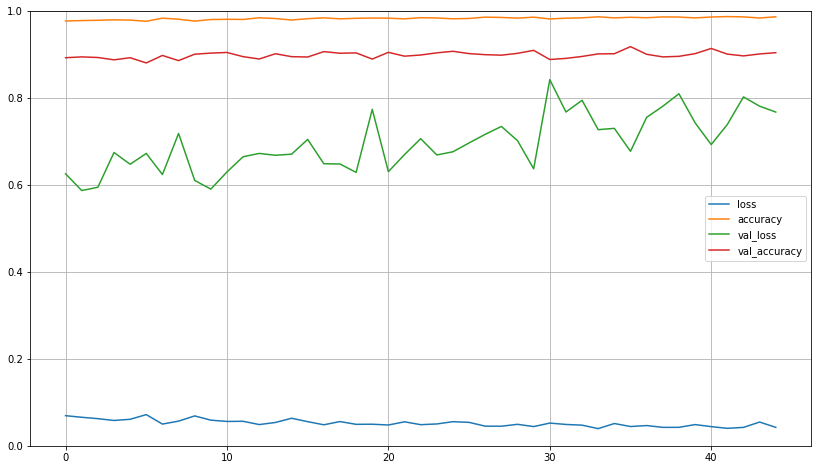

In [ ]:
pd.DataFrame(hist_vgg16.history).plot(figsize=(14,8))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### Adversarial attack

**DESCRIPTION OF The Adversarial attack to the model**:

For this section, I tried to attack the model with FGSM. \
It is a white-box attack in which the attacker perturbes the input to fool the model and the model would predict it wrong!




In [ ]:
# Function to create adversarial pattern
def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.sparse_categorical_crossentropy(label, prediction)
    
    gradient = tape.gradient(loss, image)
    
    signed_grad = tf.sign(gradient)
    
    return signed_grad

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The Original Class number :  1
The Predicted Class number :  25


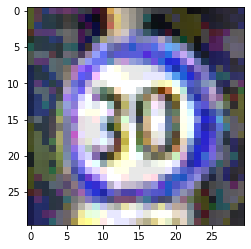

In [ ]:
# Create a signle adversarial attack example
image = x_test[1]
image_label = y_test[1]
perturbations = adversarial_pattern(image.reshape((1, 30, 30, 3)), image_label).numpy()
adversarial = image + perturbations * 0.09

print("The Original Class number : ", model.predict(image.reshape((1, 30, 30, 3))).argmax())
print("The Predicted Class number : ", model.predict(adversarial).argmax())

plt.imshow(adversarial.reshape((30, 30, 3)))
plt.show()

As you can see, the image has changed and the model predicts the classes wrong!

In [ ]:
#---------------------------------------------------